<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/wk30_case1_MNIST_Digit_recognizer_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit recognizer
1. your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images
  - Metrics : the categorization accuracy of your predictions 
2.We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks - experiment with different algorithms to learn first-hand what works well and how techniques compare.
3. Practical skills
  - Computer vision fundamentals including simple neural networks
  - Classification methods such as SVM and K-nearest neighbors

[Kaggle competition link](https://www.kaggle.com/competitions/digit-recognizer/data)<br>
[Kaggle Notebook link](https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist)

##### 이 노트북을 선택한 이유
1. an ensemble of 15 CNNs 
2. Data augmentation (42,000 > 25,000,000) - 회전/scaling/shifing 등 이용
3. Nonlinear convolution layers / learnable pooling layers / ReLU activation / ensembling / bagging / decaying learning rates / dropout / batch normalization, and adam optimization.

# 1. 라이브러리 및 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# %tensorflow_version 1.9
# Keras는 독립적인 프레임워크가 아니라 Tensorflow 1.x version 백엔드에서 실행되는 모듈임
# tf.keras는 TF 2.x version 기반이라, Keras와 약간의 차이가 있을 수 있음
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # 

# models : 전반적으로 학습 모델 구축에 사용되는 모듈
# models.Sequential() : 여러 레이어를 순차적으로 쌓아서 모델을 만듦
from keras.models import Sequential 
# layers : 신경망에서 어떤 함수를 이용해 학습하는 층을 만들지 
# layers.Dense : Densely-connected/Fully-connected NN - Arguments로 units(o/p unit 수), activation, input_shape을 가짐
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [2]:
# keras 내장 dataset을 이용할 수도 있다
# from keras.datasets import mnist
# load_data() 함수를 호출하면, 아래의 형태로 데이터를 반환함
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# LOAD THE DATA
train = pd.read_csv("/content/drive/MyDrive/2. Kaggle Struggle/digit-recognizer/train.csv")
test = pd.read_csv("/content/drive/MyDrive/2. Kaggle Struggle/digit-recognizer/test.csv")
submit = pd.read_csv("/content/drive/MyDrive/2. Kaggle Struggle/digit-recognizer/sample_submission.csv")

In [5]:
train.shape, test.shape, submit.shape

((42000, 785), (28000, 784), (28000, 2))

In [6]:
print(train.columns.tolist()), print(test.columns.tolist())

['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel90',

(None, None)

In [7]:
set(train.columns.tolist()) - set(test.columns.tolist())

{'label'}

In [8]:
# 신경망에 적용하기 위해 데이터 전처리

y_train = train['label']
X_train = train.drop(labels = ['label'], axis = 1)
print(type(X_train)) # DataFrame
print(type(X_train.values)) # numpy.ndarray

# 이미지 데이터 : 픽셀 정보를 0~255 사이 값으로 저장함. 따라서 255로 나눠줌으로써 0~1 사이 값으로 정규화
X_train = X_train / 255.0
X_test = test / 255.0

# X_train.values.shape # (42000, 784)
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

# Converts a class vector (integers) to binary class matrix
y_train = to_categorical(y_train, num_classes = 10)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [9]:
X_train.shape, X_test.shape, y_train.shape

((42000, 28, 28, 1), (28000, 28, 28, 1), (42000, 10))

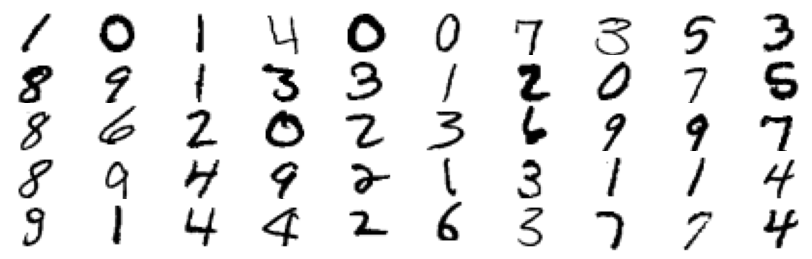

In [10]:
# 이미지 확인
plt.figure(figsize = (15, 4.5))
for i in range(50):
    plt.subplot(5, 10, i+1) # nrows, ncols, index
    plt.imshow(X_train[i].reshape((28,28)), cmap = plt.cm.binary)
    plt.axis('off')

# subplots_adjust(left, bottom, right, top, wspace, hspace) : 서브플롯 간 간격 조절 
# plt.subplots(constrained_layout=True) 이렇게 자동으로 간격 조정해주도록 하는 방법도 있음
plt.subplots_adjust(wspace = -0.1, hspace = -0.1)
plt.show()

# 2. Data Augmentation

In [11]:
# 학습에 이용할 이미지 수 증가시켜줌
datagen = ImageDataGenerator(
    rotation_range = 10, 
    zoom_range = 0.10, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1
)

datagen

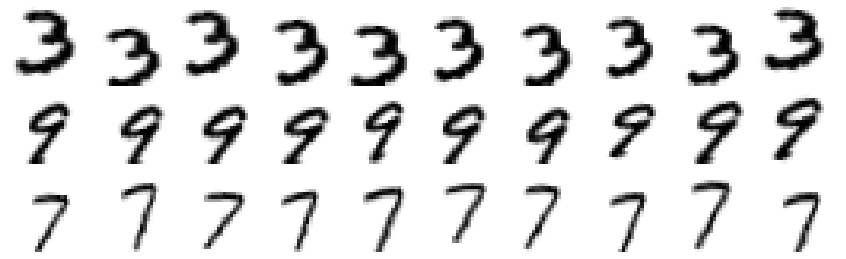

In [25]:
# augmented data 확인
X_train3 = X_train[9,].reshape((1,28,28, 1))
y_train3 = y_train[9,].reshape((1,10))
plt.figure(figsize = (15,4.5))

for i in range(30):
    plt.subplot(3,10, i+1) 
    # datagen.flow() : Takes data & label arrays, generates batches of augmented data.
    # datagen.flow().next() : Return the next item from the iterator. 
    # if default is given and the iterator is exhausted, it is returned instead of raising Stopiteration 
    X_train2, y_train2 = datagen.flow(X_train3, y_train3).next() 
    plt.imshow(X_train2[0].reshape((28,28)), cmap = plt.cm.binary)
    plt.axis('off')
    if i == 9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i == 19 : X_train3 = X_train[18,].reshape((1,28,28,1))

plt.subplots_adjust(wspace = -0.1, hspace = -0.1)
plt.show()


# 3. CNN 생성

In [28]:
# Convolutional Neural Networks
nets = 15
model = [0] * nets

for j in range(nets): 
    model[j] = Sequential()

    model[j].add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(filters = 128, kernel_size = 4, activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation = 'softmax'))

    # 컴파일 
    model[j].compile(optimizer = 'adam', 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

<img src = 'https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/LeNet5.png'><br>
The CNNs in this kernel follow LeNet5's design (pictured above) with the following improvements:<br>
    - Two stacked 3x3 filters replace the single 5x5 filters.<br> 
    These become nonlinear 5x5 convolutions<br>
    - A convolution with stride 2 replaces pooling layers.<br> 
    These become learnable pooling layers.<br>
    - ReLU activation replaces sigmoid.<br>
    - Batch normalization is added<br>
    - Dropout is added<br>
    - More feature maps (channels) are added<br>
    - An ensemble of 15 CNNs with bagging is used<br>
Experiments (here) show that each of these changes improve classification accuracy

# 4. 15 CNNs 학습

In [ ]:
# epoch마다 learning rate 낮춰줌
# anneal : 강화시키다
annealer = LearningRateScheduler(lambda x : 1e-3 * 0.95 ** x)

# train 
history = [0] * nets
epochs = 45
for j in range(nets) : 
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2, y_train2, batch_size = 64), 
                                       epochs = epochs, steps_per_epoch = X_train2.shape[0]//64, 
                                       validation_data = (X_val2, y_val2), 
                                       callbacks = [annealer], verbose = 0)
    print('CNN {0:d} : Epochs = {1:d}, Train accuracy = {2:.5f}, Validation accuracy = {3:.5f}'.format(
        j+1, epochs, max(history[j].history['acc']), max(history[j].history['val_acc'])
    ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


# 5. Ensemble 15 CNN predictions 

In [ ]:
# 예측 결과 ensemble
results = np.zeros( (X_test.shape[0], 10))

for j in range(nets):
    results = results + model[j].predict(X_test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = 'Label')
submission = pd.concat([pd.Series(range(1, 28001), name = 'ImageId'), results], axis = 1)
submission.to_csv('MNIST-CNN-ENSEMBLE.csv', index = False)

In [ ]:
# predict
plt.figure(figsize = (15, 6))
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28,28)), cmap = plt.cm.binary)
    plt.title('predict=%d' % results[i], y = 0.9)
    plt.axis('off')

plt.subplots_adjust(wspace=0.3, hspace = -0.1)
plt.show()